In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

import os

print(os.listdir("./"))


['voronezh_test_last_true.npy', 'r2_96.png', 'plot_r2_mse.ipynb', 'newvenv', '.DS_Store', 'run_baselines.py', 'requirements.txt', 'voronezh_curr_test_dataset.npy', 'mse_96.png', 'voronezh_train.npy', 'infer_1d.py', 'tests', 'test.py', 'README.md', 'voronezh_test_last_convlstm.npy', 'voronezh_test_last.npy', '.gitignore', 'configs', 'scripts', 'chkpts', 'train.py', 'infer.py', '.ipynb_checkpoints', '.git', 'data', 'src']


## Loading data

In [46]:
targets_convlstm = np.load("voronezh_test_last_true.npy")
print("targets_convsltm", targets_convlstm.shape)
predicted_values_convlstm = np.load("voronezh_test_last_convlstm.npy") 
assert targets_convlstm.shape[0] == predicted_values_convlstm.shape[1], "time dimensions must match"
print("predicted_convlstm", predicted_values_convlstm.shape)

targets_convsltm (186, 36, 40, 20)
predicted_convlstm (1, 186, 36, 40, 20)


## Rolling average predictions

In [47]:
test_values = 0.01*np.load("voronezh_curr_test_dataset.npy")
print("test_dataset", test_values.shape)

len_test = test_values.shape[0]
window_size = test_values.shape[1]
h = test_values.shape[2]
w = test_values.shape[3]
horizon = predicted_values_convlstm.shape[2]

rolling_predictions = np.zeros((len_test, horizon, h, w))
rolling_targets = np.zeros((len_test, horizon, h, w))

#curr_data = test_values[0]
for i in range(len_test):


    rolling_targets[i] = targets_convlstm[i]
    curr_data = test_values[i]
    for j in range(horizon):
        rolling_predictions[i][j] = np.mean(curr_data, axis=0)
        new_pred = np.expand_dims(rolling_predictions[i][j], axis=0)
        curr_data = np.vstack((curr_data[1:], new_pred))
    #print(curr_data.shape)
    #print(rolling_predictions[i].shape)
   

print("rolling_predictions", rolling_predictions.shape)
print("rolling_targets", rolling_targets.shape)

test_dataset (186, 36, 40, 20)
rolling_predictions (186, 36, 40, 20)
rolling_targets (186, 36, 40, 20)


In [35]:
test_values.min()

-7.29385

## MSE vs horizon

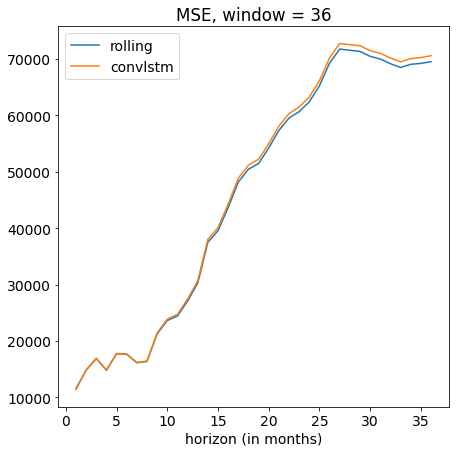

In [48]:
from sklearn.metrics import mean_squared_error
import seaborn as sns

plt.rcParams.update({'font.size': 14})

mse_rolling = []
mse_convlstm = [[] for i in range(predicted_values_convlstm.shape[0])]
forecast_horizon = targets_convlstm.shape[1]


for i in range(1, forecast_horizon+1):
    
    mean_true = rolling_targets[:i, 0, :, :]
    mean_rolling = rolling_predictions[:i, 0, :, :]
    mse_rolling.append(((mean_rolling - mean_true)**2).mean())
    

    mean_true = targets_convlstm[:i, 0, :, :]
    for k in range(predicted_values_convlstm.shape[0]):
        mean_predicted = predicted_values_convlstm[k][:i, 0, :, :]
        mse_convlstm[k].append(((mean_predicted - mean_true)**2).mean())
        
        
h = [i for i in range(1, forecast_horizon+1)]

fig1 = plt.figure(figsize=(7, 7))
ax = fig1.add_subplot(1, 1, 1)
sns.lineplot(x=h, y=mse_rolling, ax = ax)
for i in range(predicted_values_convlstm.shape[0]):
     sns.lineplot(x=h, y=mse_convlstm[i], ax = ax)
ax.legend(['rolling', 'convlstm'])
ax.set_xlabel("horizon (in months)")
ax.set_title("MSE, window = " + str(window_size))

fig1.savefig("mse_" + str(window_size) + ".png", bbox_inches='tight', dpi=400)


## R^2 vs horizon

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


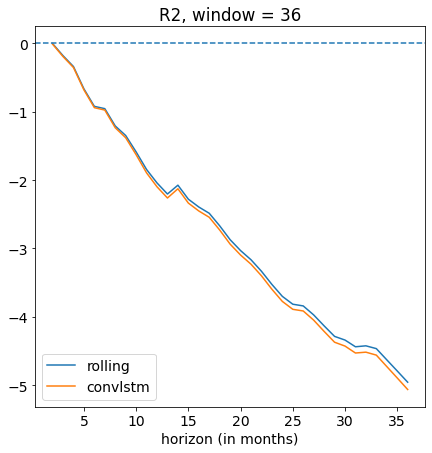

In [49]:
from sklearn.metrics import r2_score
import seaborn as sns

plt.rcParams.update({'font.size': 14})

r2_rolling = []
r2_convlstm = [[] for i in range(predicted_values_convlstm.shape[0])]

for i in range(1, forecast_horizon+1):
    mean_true = np.mean(rolling_targets[:i, 0, :, :], axis=(1, 2))
    mean_rolling = np.mean(rolling_predictions[:i, 0, :, :], axis=(1, 2))
    r2_rolling.append(r2_score(mean_true, mean_rolling))
    
    mean_true = np.mean(targets_convlstm[:i, 0, :, :], axis=(1, 2))
    
    for k in range(predicted_values_convlstm.shape[0]):
        mean_predicted = np.mean(predicted_values_convlstm[k][:i, 0, :, :], axis=(1, 2))
        r2_convlstm[k].append(r2_score(mean_true, mean_predicted))
        

h = [i for i in range(1, forecast_horizon+1)]

fig1 = plt.figure(figsize=(7, 7))
ax = fig1.add_subplot(1, 1, 1)
sns.lineplot(x=h, y=r2_rolling, ax = ax)
for i in range(predicted_values_convlstm.shape[0]):
    sns.lineplot(x=h, y=r2_convlstm[i], ax = ax)
ax.legend(['rolling', 'convlstm'])
ax.set_xlabel("horizon (in months)")
ax.set_title("R2, window = " + str(window_size))
ax.axhline(0.0, ls="--")

fig1.savefig("r2_" + str(window_size) + ".png", bbox_inches='tight', dpi=400)
